In [ ]:
# DEPENDENCIES
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import re
from collections import Counter
import os
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from scipy.spatial.distance import cdist
from sklearn.cluster import KMeans
import os

In [131]:
# PATHS:
output_dir = r"C:\Users\sandr\Documents\scrp_tiktok_tfg\analysis\Kmeans\Kmeans_results"

# DATA LOAD:
brands_data_path = r"C:\Users\sandr\Documents\scrp_tiktok_tfg\analysis\Kmeans\data for kmeans\brand_meaningful_terms_forkmeans.xlsx"
detection_data_path = r"C:\Users\sandr\Documents\scrp_tiktok_tfg\analysis\Detection\detection_results\corrected_results_detections.xlsx"
brands_df = pd.read_excel(brands_data_path)
detection_df = pd.read_excel(detection_data_path)

In [ ]:
# TERM FRECUENCY

all_terms = []
brand_terms = {}

for _, row in brands_df.iterrows():
    brand = row['brand']
    terms = str(row['representative_terms']).lower().split(', ')
    brand_terms[brand] = terms
    all_terms.extend(terms)

term_counts = Counter(all_terms)
print(f"Total unique terms: {len(term_counts)}")
top_terms = [term for term, count in term_counts.most_common(100) if term != 'nan']

Total unique terms: 762


In [ ]:
# Feature matrix
brand_features = pd.DataFrame(index=brands_df['brand'].unique())

for _, row in brands_df.iterrows():# Add price feature
    brand_features.loc[row['brand'], 'avg_price'] = row['avg_price']
    brand_features.loc[row['brand'], 'num_products'] = row['num_products']

for term in top_terms: # Add term features (binary representation)
    brand_features[term] = 0
    for brand, terms in brand_terms.items():
        if term in terms:
            brand_features.loc[brand, term] = 1

sentiments = {} # Enhance with sentiment
for brand in brand_features.index:
    brand_sentiments = detection_df[detection_df['brand_detected'] == brand]['sentiment_score']
    if not brand_sentiments.empty:
        sentiments[brand] = brand_sentiments.mean()
    else:
        sentiments[brand] = np.nan

brand_features['avg_sentiment'] = pd.Series(sentiments)

brand_features = brand_features.fillna(brand_features.mean())# for missing values

C:\Users\sandr\AppData\Local\Temp\ipykernel_33816\268607993.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_features[term] = 0
C:\Users\sandr\AppData\Local\Temp\ipykernel_33816\268607993.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_features[term] = 0
C:\Users\sandr\AppData\Local\Temp\ipykernel_33816\268607993.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.

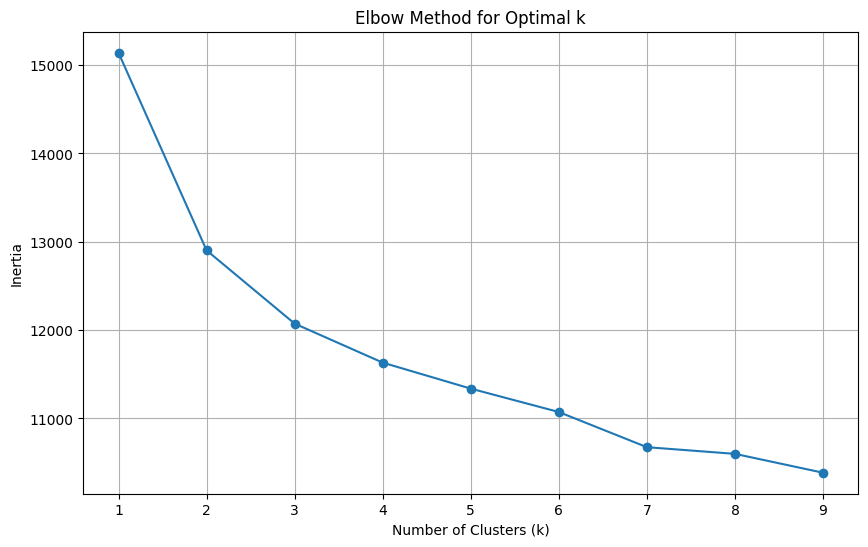

In [ ]:
X = brand_features.copy()
X_scaled = StandardScaler().fit_transform(X)

# ELBOW METHOD:
inertia = []
k_range = range(1, 10)
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(k_range, inertia, 'o-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.grid(True)
plt.show()

In [ ]:
n_clusters = 3 
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
brand_features['cluster'] = kmeans.fit_predict(X_scaled)
brand_features.to_excel(os.path.join(output_dir, 'brand_clusters.xlsx'))

C:\Users\sandr\AppData\Local\Temp\ipykernel_33816\2608792520.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_features['cluster'] = kmeans.fit_predict(X_scaled)


In [ ]:
# CLUSTER Summary
cluster_centroids = pd.DataFrame(kmeans.cluster_centers_, columns=X.columns)
cluster_sizes = brand_features['cluster'].value_counts().sort_index()
print("\nCluster sizes:")
print(cluster_sizes)

print("\nCluster centroids:")
print(cluster_centroids)


Cluster sizes:
cluster
0    38
1    63
2    46
Name: count, dtype: int64

Cluster centroids:
   avg_price  num_products       oil   natural  hyaluronic acid      balm  \
0  -0.055515     -0.322064  0.358242  0.458695         0.188116  0.214870   
1   0.129404     -0.641427 -0.486854 -0.700142        -0.658586 -0.565309   
2  -0.131367      1.144529  0.370839  0.579969         0.746576  0.596726   

   hydrating     shine     cream     vegan  ...  alcohol-free      aloe  \
0   0.545280  0.005018  0.269967  0.427865  ...     -0.165658  0.461425   
1  -0.614653 -0.699206 -0.802740  0.149663  ...     -0.270172 -0.081051   
2   0.391359  0.953463  0.876388 -0.558428  ...      0.506865 -0.270172   

     tested      long      glow  formaldehyde      your  customizable  \
0 -0.165658 -0.270172 -0.270172     -0.270172 -0.270172      0.293459   
1  0.297189  0.360229  0.360229      0.360229  0.360229      0.009458   
2 -0.270172 -0.270172 -0.270172     -0.270172 -0.270172     -0.255377   

   

In [137]:
# PCA to visualize clusters in 2D
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(12, 8))
for i in range(n_clusters):
    plt.scatter(
        X_pca[brand_features['cluster'] == i, 0],
        X_pca[brand_features['cluster'] == i, 1],
        label=f'Cluster {i}',
        alpha=0.7,
        s=100
    )
for i, brand in enumerate(brand_features.index):
    plt.annotate(
        brand,
        (X_pca[i, 0], X_pca[i, 1]),
        fontsize=9,
        alpha=0.8
    )

plt.title('PCA Cluster Visualization', fontsize=15)
plt.xlabel('Principal Component 1', fontsize=12)
plt.ylabel('Principal Component 2', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig(os.path.join(output_dir, 'cluster_pca_visualization.png'))
plt.close()

In [ ]:
# Radar charts 
def radar_chart(cluster_id):
    numeric_features = []
    for term in top_terms:
        if pd.api.types.is_numeric_dtype(brand_features[term]):
            numeric_features.append(term)

    feature_importance = {}
    for feature in numeric_features:
        all_clusters_mean = []
        for i in range(n_clusters):
            cluster_mean = brand_features[brand_features['cluster'] == i][feature].mean()
            all_clusters_mean.append(cluster_mean)
        if np.argmax(all_clusters_mean) == cluster_id:
            feature_importance[feature] = all_clusters_mean[cluster_id]
    
    # Sort features by importance and take top 8
    radar_features = sorted(feature_importance.keys(), 
                           key=lambda x: feature_importance[x], 
                           reverse=True)[:8]
    if len(radar_features) < 5:
        radar_features = numeric_features[:8]
    cluster_brands = brand_features[brand_features['cluster'] == cluster_id].index
    
    values = []
    for feature in radar_features:
        values.append(float(brand_features.loc[cluster_brands, feature].mean()))
    
    # Normalize values between 0 and 1 for radar chart
    min_val = min(values)
    max_val = max(values)
    if max_val > min_val:
        normalized_values = [(val - min_val) / (max_val - min_val) for val in values]
    else:
        normalized_values = [0.5 for _ in values]
    
    N = len(radar_features)
    angles = [n / float(N) * 2 * np.pi for n in range(N)]
    normalized_values.append(normalized_values[0])
    angles.append(angles[0])
    
    # PLOT:
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, polar=True)
    ax.plot(angles, normalized_values, 'o-', linewidth=2, color='blue')
    ax.fill(angles, normalized_values, color='blue', alpha=0.25)
    
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(radar_features, size=12)

    plt.title(f"Cluster {cluster_id}: Principales Características", size=15, y=1.1)
    ax.grid(True)
    
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, f'cluster_{cluster_id}_radar.png'))
    plt.close()
    
    return fig

for i in range(n_clusters):
    radar_chart(i)


In [139]:
# Heatmaps of feature importance for each cluster
numeric_terms = []
for term in top_terms:
    try:
        brand_features[term] = pd.to_numeric(brand_features[term], errors='coerce')
        numeric_terms.append(term)
    except:
        print(f"Skipping non-numeric term: {term}")
plt.figure(figsize=(15, 10))
cluster_feature_importance = pd.DataFrame(index=range(n_clusters), columns=numeric_terms)

for i in range(n_clusters):
    cluster_brands = brand_features[brand_features['cluster'] == i].index
    for term in numeric_terms:
        cluster_feature_importance.loc[i, term] = brand_features.loc[cluster_brands, term].astype(float).mean()
cluster_feature_importance = cluster_feature_importance.astype(float)

for col in cluster_feature_importance.columns:
    min_val = cluster_feature_importance[col].min()
    max_val = cluster_feature_importance[col].max()
    if max_val > min_val:  # Avoid division by zero
        cluster_feature_importance[col] = (cluster_feature_importance[col] - min_val) / (max_val - min_val)
    else:
        cluster_feature_importance[col] = 0.5  # Default value if all values are the same

try:
    sns.heatmap(cluster_feature_importance, annot=True, cmap='YlGnBu', fmt='.2f')
    plt.title('Feature Importance by Cluster', fontsize=15)
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, 'cluster_feature_heatmap.png'))
except Exception as e:
    print(f"Error creating heatmap: {str(e)}")
    plt.figure(figsize=(15, 10))
    plt.imshow(cluster_feature_importance.values, cmap='YlGnBu', aspect='auto')
    plt.yticks(range(len(cluster_feature_importance.index)), cluster_feature_importance.index)
    plt.xticks(range(len(cluster_feature_importance.columns)), cluster_feature_importance.columns, rotation=90)
    plt.colorbar()
    plt.title('Feature Importance by Cluster (Alternative Visualization)', fontsize=15)
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, 'cluster_feature_heatmap_alt.png'))
plt.close()

In [140]:
all_attributes = []
for attr in detection_df['detected_attributes'].dropna():
    if isinstance(attr, str):
        attributes = attr.lower().split(', ')
        all_attributes.extend([a.strip() for a in attributes if a.strip()])

attribute_counts = Counter(all_attributes)
top_attributes = [attr for attr, count in attribute_counts.most_common(30) if attr != '']

# Attribute matrix for each brand
brand_attributes = pd.DataFrame(index=brand_features.index, columns=top_attributes).fillna(0)

for _, row in detection_df.dropna(subset=['brand_detected', 'detected_attributes']).iterrows():
    brand = row['brand_detected']
    if brand in brand_attributes.index and isinstance(row['detected_attributes'], str):
        attrs = row['detected_attributes'].lower().split(', ')
        for attr in attrs:
            attr = attr.strip()
            if attr in top_attributes:
                brand_attributes.loc[brand, attr] += 1

# Normalize by number of mentions
for brand in brand_attributes.index:
    mentions = detection_df[detection_df['brand_detected'] == brand].shape[0]
    if mentions > 0:
        brand_attributes.loc[brand] = brand_attributes.loc[brand] / mentions

brand_attributes['cluster'] = brand_features['cluster']
plt.figure(figsize=(15, 8))

string_attributes = []
for attr in top_attributes:
    string_attributes.append(str(attr))

cluster_attr_importance = pd.DataFrame(index=range(n_clusters), columns=string_attributes)

for i in range(n_clusters):
    cluster_brands = brand_attributes[brand_attributes['cluster'] == i].index
    for attr in string_attributes:
        if attr in brand_attributes.columns:
            # Force numeric conversion
            values = pd.to_numeric(brand_attributes.loc[cluster_brands, attr], errors='coerce')
            cluster_attr_importance.loc[i, attr] = values.mean()
        else:
            cluster_attr_importance.loc[i, attr] = 0.0

cluster_attr_importance = cluster_attr_importance.fillna(0)
cluster_attr_importance = cluster_attr_importance.astype(float)

for col in cluster_attr_importance.columns:
    min_val = cluster_attr_importance[col].min()
    max_val = cluster_attr_importance[col].max()
    if max_val > min_val:  # Avoid division by zero
        cluster_attr_importance[col] = (cluster_attr_importance[col] - min_val) / (max_val - min_val)
    else:
        cluster_attr_importance[col] = 0.5  # Default value if all values are the same
try:
    sns.heatmap(cluster_attr_importance, annot=True, cmap='YlGnBu', fmt='.2f')
    plt.title('Attribute Association by Cluster', fontsize=15)
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, 'cluster_attribute_heatmap.png'))
except Exception as e:
    print(f"Error creating attribute heatmap: {str(e)}")
    # Alternative visualization
    plt.figure(figsize=(15, 8))
    plt.imshow(cluster_attr_importance.values, cmap='YlGnBu', aspect='auto')
    plt.yticks(range(len(cluster_attr_importance.index)), cluster_attr_importance.index)
    plt.xticks(range(len(cluster_attr_importance.columns)), cluster_attr_importance.columns, rotation=90)
    plt.colorbar()
    plt.title('Attribute Association by Cluster (Alternative)', fontsize=15)
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, 'cluster_attribute_heatmap_alt.png'))

plt.close()


C:\Users\sandr\AppData\Local\Temp\ipykernel_33816\2597444900.py:11: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  brand_attributes = pd.DataFrame(index=brand_features.index, columns=top_attributes).fillna(0)
C:\Users\sandr\AppData\Local\Temp\ipykernel_33816\2597444900.py:26: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.3076923076923077' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  brand_attributes.loc[brand] = brand_attributes.loc[brand] / mentions
C:\Users\sandr\AppData\Local\Temp\ipykernel_33816\2597444900.py:26: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '

In [ ]:
# Summary description for each cluster
cluster_summary = {}

for i in range(n_clusters):
    cluster_brands = brand_features[brand_features['cluster'] == i].index.tolist()
    
    avg_price = brand_features[brand_features['cluster'] == i]['avg_price'].mean()
    avg_sentiment = brand_features[brand_features['cluster'] == i]['avg_sentiment'].mean()
    
    # Top features:
    try:
        top_features = cluster_feature_importance.loc[i].sort_values(ascending=False).head(5)
        cluster_terms = top_features.index.tolist()
    except Exception as e:
        cluster_terms = []
        print(f"Warning: Could not extract top terms for cluster {i}: {str(e)}")
    try:
        top_attrs = cluster_attr_importance.loc[i].sort_values(ascending=False).head(5)
        cluster_attrs = top_attrs.index.tolist()
    except Exception as e:
        cluster_attrs = []
        print(f"Warning: Could not extract top attributes for cluster {i}: {str(e)}")
    summary = {
        "brands": cluster_brands,
        "count": len(cluster_brands),
        "avg_price": avg_price,
        "avg_sentiment": avg_sentiment,
        "top_terms": cluster_terms,
        "top_attributes": cluster_attrs
    }
    
    cluster_summary[f"Cluster_{i}"] = summary

# Save:
cluster_summary_df = pd.DataFrame.from_dict(cluster_summary, orient='index')
cluster_summary_df.to_excel(os.path.join(output_dir, 'cluster_summary.xlsx'))

Analysis complete. Results saved to: C:\Users\sandr\Documents\scrp_tiktok_tfg\analysis\Kmeans\Kmeans_results


In [ ]:
# K-MEANS EVALUATION AFTER PCA
print("\n" + "="*50)
print("EVALUACIÓN DE K-MEANS DESPUÉS DE REDUCCIÓN PCA")
print("="*50)

output_dir = os.path.join(output_dir, 'pca_evaluation')

# Apply to different PCA numbers
n_components_list = [2, 3, 5, 10, 15]
metrics_results = []

for n_components in n_components_list:
    print(f"\nEvaluación con PCA de {n_components} componentes:")

    pca = PCA(n_components=n_components)
    X_pca = pca.fit_transform(X_scaled)
    
    explained_variance = np.sum(pca.explained_variance_ratio_) * 100
    print(f"Varianza explicada: {explained_variance:.2f}%")
    
    kmeans_pca = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    cluster_labels_pca = kmeans_pca.fit_predict(X_pca)
    
    # Metrics
    metrics = {}
    metrics['n_components'] = n_components
    metrics['explained_variance'] = explained_variance
    
    metrics['inercia'] = kmeans_pca.inertia_
    print(f"1. Inercia (WCSS): {kmeans_pca.inertia_:.4f}")
    
    # Silouette Score
    try:
        silhouette_avg = silhouette_score(X_pca, cluster_labels_pca)
        metrics['silhouette'] = silhouette_avg
        print(f"2. Coeficiente de Silueta: {silhouette_avg:.4f}")
        
        from sklearn.metrics import silhouette_samples
        sample_silhouette_values = silhouette_samples(X_pca, cluster_labels_pca)
        for i in range(n_clusters):
            cluster_silhouette = sample_silhouette_values[cluster_labels_pca == i].mean()
            metrics[f'silhouette_cluster_{i}'] = cluster_silhouette
            print(f"   - Silueta promedio para Cluster {i}: {cluster_silhouette:.4f}")
    except Exception as e:
        print(f"Error al calcular Coeficiente de Silueta: {e}")
    
    # Davies-Bouldin
    try:
        db_score = davies_bouldin_score(X_pca, cluster_labels_pca)
        metrics['davies_bouldin'] = db_score
        print(f"3. Índice Davies-Bouldin: {db_score:.4f}")
    except Exception as e:
        print(f"Error al calcular Índice Davies-Bouldin: {e}")
    
    # Calinski-Harabasz
    try:
        ch_score = calinski_harabasz_score(X_pca, cluster_labels_pca)
        metrics['calinski_harabasz'] = ch_score
        print(f"4. Índice Calinski-Harabasz: {ch_score:.4f}")
    except Exception as e:
        print(f"Error al calcular Índice Calinski-Harabasz: {e}")
    
    try:
        distortion = np.sum(np.min(cdist(X_pca, kmeans_pca.cluster_centers_, 'euclidean'), axis=1)) / X_pca.shape[0]
        metrics['distorsion'] = distortion
        print(f"5. Distorsión: {distortion:.4f}")
    except Exception as e:
        print(f"Error al calcular Distorsión: {e}")
    
    metrics_results.append(metrics)
    
    # 2D graph
    if n_components == 2:
        plt.figure(figsize=(12, 8))
        scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=cluster_labels_pca, cmap='viridis', s=100, alpha=0.7)
        plt.scatter(kmeans_pca.cluster_centers_[:, 0], kmeans_pca.cluster_centers_[:, 1], 
                   c='red', marker='X', s=200, label='Centroids')
        
        plt.title(f'PCA (2 componentes) + K-Means (k={n_clusters})\nSilhouette: {silhouette_avg:.4f}, Davies-Bouldin: {db_score:.4f}', fontsize=15)
        plt.xlabel('Componente Principal 1', fontsize=12)
        plt.ylabel('Componente Principal 2', fontsize=12)
        plt.legend(*scatter.legend_elements(), title="Clusters")
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.savefig(os.path.join(output_dir, 'pca_2d_kmeans.png'), dpi=300)
        plt.close()

metrics_df = pd.DataFrame(metrics_results)
print("\nComparación de métricas para diferentes dimensiones PCA:")
print(metrics_df)

metrics_df.to_excel(os.path.join(output_dir, 'pca_kmeans_metrics.xlsx'))

plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
plt.plot(metrics_df['n_components'], metrics_df['silhouette'], 'o-', color='blue')
plt.xlabel('Número de componentes PCA')
plt.ylabel('Coeficiente de Silueta')
plt.title('Silueta vs Componentes PCA')
plt.grid(True)

plt.subplot(2, 2, 2)
plt.plot(metrics_df['n_components'], metrics_df['davies_bouldin'], 'o-', color='red')
plt.xlabel('Número de componentes PCA')
plt.ylabel('Índice Davies-Bouldin')
plt.title('Davies-Bouldin vs Componentes PCA')
plt.grid(True)

plt.subplot(2, 2, 3)
plt.plot(metrics_df['n_components'], metrics_df['calinski_harabasz'], 'o-', color='green')
plt.xlabel('Número de componentes PCA')
plt.ylabel('Índice Calinski-Harabasz')
plt.title('Calinski-Harabasz vs Componentes PCA')
plt.grid(True)

plt.subplot(2, 2, 4)
plt.plot(metrics_df['n_components'], metrics_df['explained_variance'], 'o-', color='purple')
plt.xlabel('Número de componentes PCA')
plt.ylabel('Varianza explicada (%)')
plt.title('Varianza explicada vs Componentes PCA')
plt.grid(True)

plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'pca_metrics_evolution.png'), dpi=300)
plt.close()

print("\nEvaluación con PCA completa. Gráficos guardados en:", output_dir)

# Relation between cluster number and PCA
plt.figure(figsize=(15, 10))

best_k_values = []
silhouette_values = []

for n_comp in n_components_list:
    pca = PCA(n_components=n_comp)
    X_reduced = pca.fit_transform(X_scaled)
    k_range = range(2, 8)
    k_silhouette = []
    
    for k in k_range:
        kmeans_test = KMeans(n_clusters=k, random_state=42, n_init=10)
        labels = kmeans_test.fit_predict(X_reduced)
        try:
            sil = silhouette_score(X_reduced, labels)
            k_silhouette.append(sil)
        except:
            k_silhouette.append(0)
    best_k = k_range[np.argmax(k_silhouette)]
    best_sil = max(k_silhouette)
    
    best_k_values.append(best_k)
    silhouette_values.append(best_sil)
    
    plt.subplot(2, 3, n_components_list.index(n_comp) + 1)
    plt.plot(k_range, k_silhouette, 'o-')
    plt.axvline(x=best_k, color='r', linestyle='--')
    plt.xlabel('Número de clusters (k)')
    plt.ylabel('Coeficiente de Silueta')
    plt.title(f'PCA {n_comp} componentes\nMejor k = {best_k}, Silueta = {best_sil:.4f}')
    plt.grid(True)

plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'optimal_k_by_pca_dimensions.png'), dpi=300)
plt.close()

optimal_k_df = pd.DataFrame({
    'n_components': n_components_list,
    'best_k': best_k_values,
    'silhouette': silhouette_values
})

print("\nNúmero óptimo de clusters para diferentes dimensiones PCA:")
print(optimal_k_df)
optimal_k_df.to_excel(os.path.join(output_dir, 'optimal_k_by_dimensions.xlsx'))

print("\nAnálisis de número óptimo de clusters por dimensión PCA completado.")


EVALUACIÓN DE K-MEANS DESPUÉS DE REDUCCIÓN PCA

Evaluación con PCA de 2 componentes:
Varianza explicada: 23.67%
1. Inercia (WCSS): 606.1392
2. Coeficiente de Silueta: 0.5684
   - Silueta promedio para Cluster 0: 0.5818
   - Silueta promedio para Cluster 1: 0.6459
   - Silueta promedio para Cluster 2: 0.4645
3. Índice Davies-Bouldin: 0.5827
4. Índice Calinski-Harabasz: 353.7105
5. Distorsión: 1.7757

Evaluación con PCA de 3 componentes:
Varianza explicada: 27.90%
1. Inercia (WCSS): 1240.6385
2. Coeficiente de Silueta: 0.4476
   - Silueta promedio para Cluster 0: 0.5987
   - Silueta promedio para Cluster 1: 0.3800
   - Silueta promedio para Cluster 2: 0.3702
3. Índice Davies-Bouldin: 0.8548
4. Índice Calinski-Harabasz: 173.1408
5. Distorsión: 2.5853

Evaluación con PCA de 5 componentes:
Varianza explicada: 33.98%
1. Inercia (WCSS): 2139.3251
2. Coeficiente de Silueta: 0.3600
   - Silueta promedio para Cluster 0: 0.5452
   - Silueta promedio para Cluster 1: 0.2711
   - Silueta promedio p